# Figure 6
Aerosol profiles for each flight. Profiles are resampled with averaging over 10 seconds to reduce influence of counting artefacts.
Tbh, after the changes required by the reviewer, this should have been a script rather than a notebook.

In [1]:
# Standard Library
import os
from glob import glob
import datetime as dt

# Others
import pandas as pd
import numpy as np
import xarray as xr 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.colors as mcolors

import faamasd as asd

import warnings
warnings.simplefilter("ignore", category=FutureWarning) # for FutureWarning only

## Produce particle-size distribution data

In [2]:
base = '/home/users/erinraif/acao_data/probe_calibration/'
pcasp_scattering_inputs = asd.pcasp_scattering_inputs
cdp_scattering_inputs = asd.cdp_scattering_inputs
cdp_channel_data_folder = base + 'channel_data_CDP'
pcasp_channel_data_folder = base + 'channel_data_PCASP'
attribute_file = base + 'attributes_for_calibration_arrays.txt' # Set to None if not present

In [3]:
pcasp_calibration = asd.produce_calibration_dataset(pcasp_channel_data_folder,pcasp_scattering_inputs,
                                                    attribute_file)
cdp_calibration = asd.produce_calibration_dataset(cdp_channel_data_folder,cdp_scattering_inputs,attribute_file)
pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
cdp_cal_at_ri = cdp_calibration.sel(refractive_index = 1.56+0j)


## Get timings of flights and filter legs

In [4]:
leg_timings_data = pd.read_csv(
    '/home/users/erinraif/acao_data/metadata/timings_of_filter_legs_acao.csv',
    index_col='unique_ID')
leg_timings_data = leg_timings_data[leg_timings_data['psd_available'] == True]
leg_timings_data = leg_timings_data.drop(['c276r3t','c278r3t'])

In [5]:
flight_timings = pd.read_csv(
                '/home/users/erinraif/acao_data/metadata/acao_flight_timings.csv',
                index_col='flight', parse_dates=['start','stop'])
flight_timings = flight_timings.drop(['c271','c272'])
for t in ['start','stop']:
    flight_timings[t] = flight_timings[t].dt.strftime('%H:%M:%S')

In [6]:
def get_leg_timings(metadata_row):
    """Retrieve filter run timings, including pauses.
    
    Returns a list of consecutive times as ints in SPM. This is in the format
    [start, (pause1 start), (pause1 end), ..., end]
    where pauses are only present where necessary.
    
    Parameters
    ----------
    metadata_row: pandas Series
        row of the metadata pandas dataframe
    
    Returns
    -------
    list of ints
        times in SPM of run events
    """
    leg_start_times = [metadata_row.start_time]
    leg_end_times = [metadata_row.end_time]
    pauses = metadata_row.no_pauses
    for i in range(pauses):
        start_str = 'metadata_row.pause' + str(i+1) + '_end'
        end_str = 'metadata_row.pause' + str(i+1) + '_start'
        leg_start_times.append(eval(start_str))
        leg_end_times.insert(i, eval(end_str))
    return leg_start_times, leg_end_times

## Get particle number count during the appropriate periods

In [7]:
def time_average_array(da, N):
    """Time-average the data over N-second intervals.

    Returns a DataArray that has been time-averaged, while adding
    latitude co-ordinates if appropriate for later processing.

    Parameters
    ----------
    da: xarray DataArray
        dataarray to average
    N: int
        number of seconds

    Returns
    -------
    xarray DataArray
        time-averaged dataarray
    """

    # Convert spm to datetime object with arbitrary date
    da['time'] = np.datetime64('1970-01-01') + np.timedelta64(1,'s') * da['time']
    time_str = str(N)+'S'
    avgd = da.resample(time=time_str).mean()
    if 'LAT_GIN' in da.coords:
        # resample latitude if in original dataArray
        resampled_lat = da.coords['LAT_GIN'].resample(time=time_str).mean()
        avgd.coords['LAT_GIN'] = resampled_lat
    if 'LON_GIN' in da.coords:
        # resample latitude if in original dataArray
        resampled_lon = da.coords['LON_GIN'].resample(time=time_str).mean()
        avgd.coords['LON_GIN'] = resampled_lon
    return avgd

In [8]:
def get_plot_info(flight_data,nev_flag,start,end,avg_time):
    # Get Nevzorov flag data
    nev_flag = asd.time_slice_data(flight_start, flight_end, nev_flag)

    # Get PCASP and CDP data
    uncorrected_pcasp, corrected_pcasp, pcasp_flow = asd.get_pcasp_data_for_leg(flight_data, start, end)
    uncorrected_cdp, corrected_cdp, cdp_flow = asd.get_cdp_data_for_leg(flight_data, start, end)
    pcasp_psds = asd.get_log_psds(pcasp_cal_at_ri, uncorrected_pcasp, corrected_pcasp, pcasp_flow, bin_merging=True)
    #pcasp_psds = pcasp_psds.where(pcasp_psds['lin_log_diameter'] > 0.5, drop=True)
    
    # Apply mask to remove times where RH > 80% or in-cloud.
    rh_liq = asd.time_slice_data(start, end, flight_data['RH_LIQ'])
    rh_uncorrected_cdp = asd.mask_humidity_above_threshold(uncorrected_cdp, rh_liq, 80)
    rh_corrected_cdp = asd.mask_humidity_above_threshold(corrected_cdp, rh_liq, 80)
    nev_uncorrected_cdp = asd.apply_nevzorov_mask(rh_uncorrected_cdp, nev_flag)
    nev_corrected_cdp = asd.apply_nevzorov_mask(rh_corrected_cdp, nev_flag)

    masked_cdp_psds = asd.get_log_psds(cdp_cal_at_ri, nev_uncorrected_cdp, nev_corrected_cdp, cdp_flow)
    masked_cdp_psds =  masked_cdp_psds.where(masked_cdp_psds['lin_log_diameter'] < 10, drop=True)
    altitude = asd.time_slice_data(start, end, asd.create_single_dimension(flight_data.ALT_GIN))

    dN, dS, dV, dN_err, dS_err, dV_err = asd.integrate_distribution_with_errors_over_time(
                                            pcasp_psds.sel(bin=slice(2,29)),
                                            masked_cdp_psds)
    altitude_at_dN_times = altitude.interp_like(dN)
    dN = time_average_array(dN,avg_time)
    altitude_at_dN_times = time_average_array(altitude_at_dN_times,avg_time)
    dN.coords['LON_GIN'] = altitude_at_dN_times['LON_GIN']
    dN.coords['LAT_GIN'] = altitude_at_dN_times['LAT_GIN']
    return dN, altitude_at_dN_times

In [9]:
INP_concentrations = pd.read_csv('/home/users/erinraif/acao_data/inp_data/INP_concentrations.csv', index_col='temp_bin')

In [10]:
annotations = pd.read_csv('aerosol_annotations.csv')

/tmp/ipykernel_4230/1905870398.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


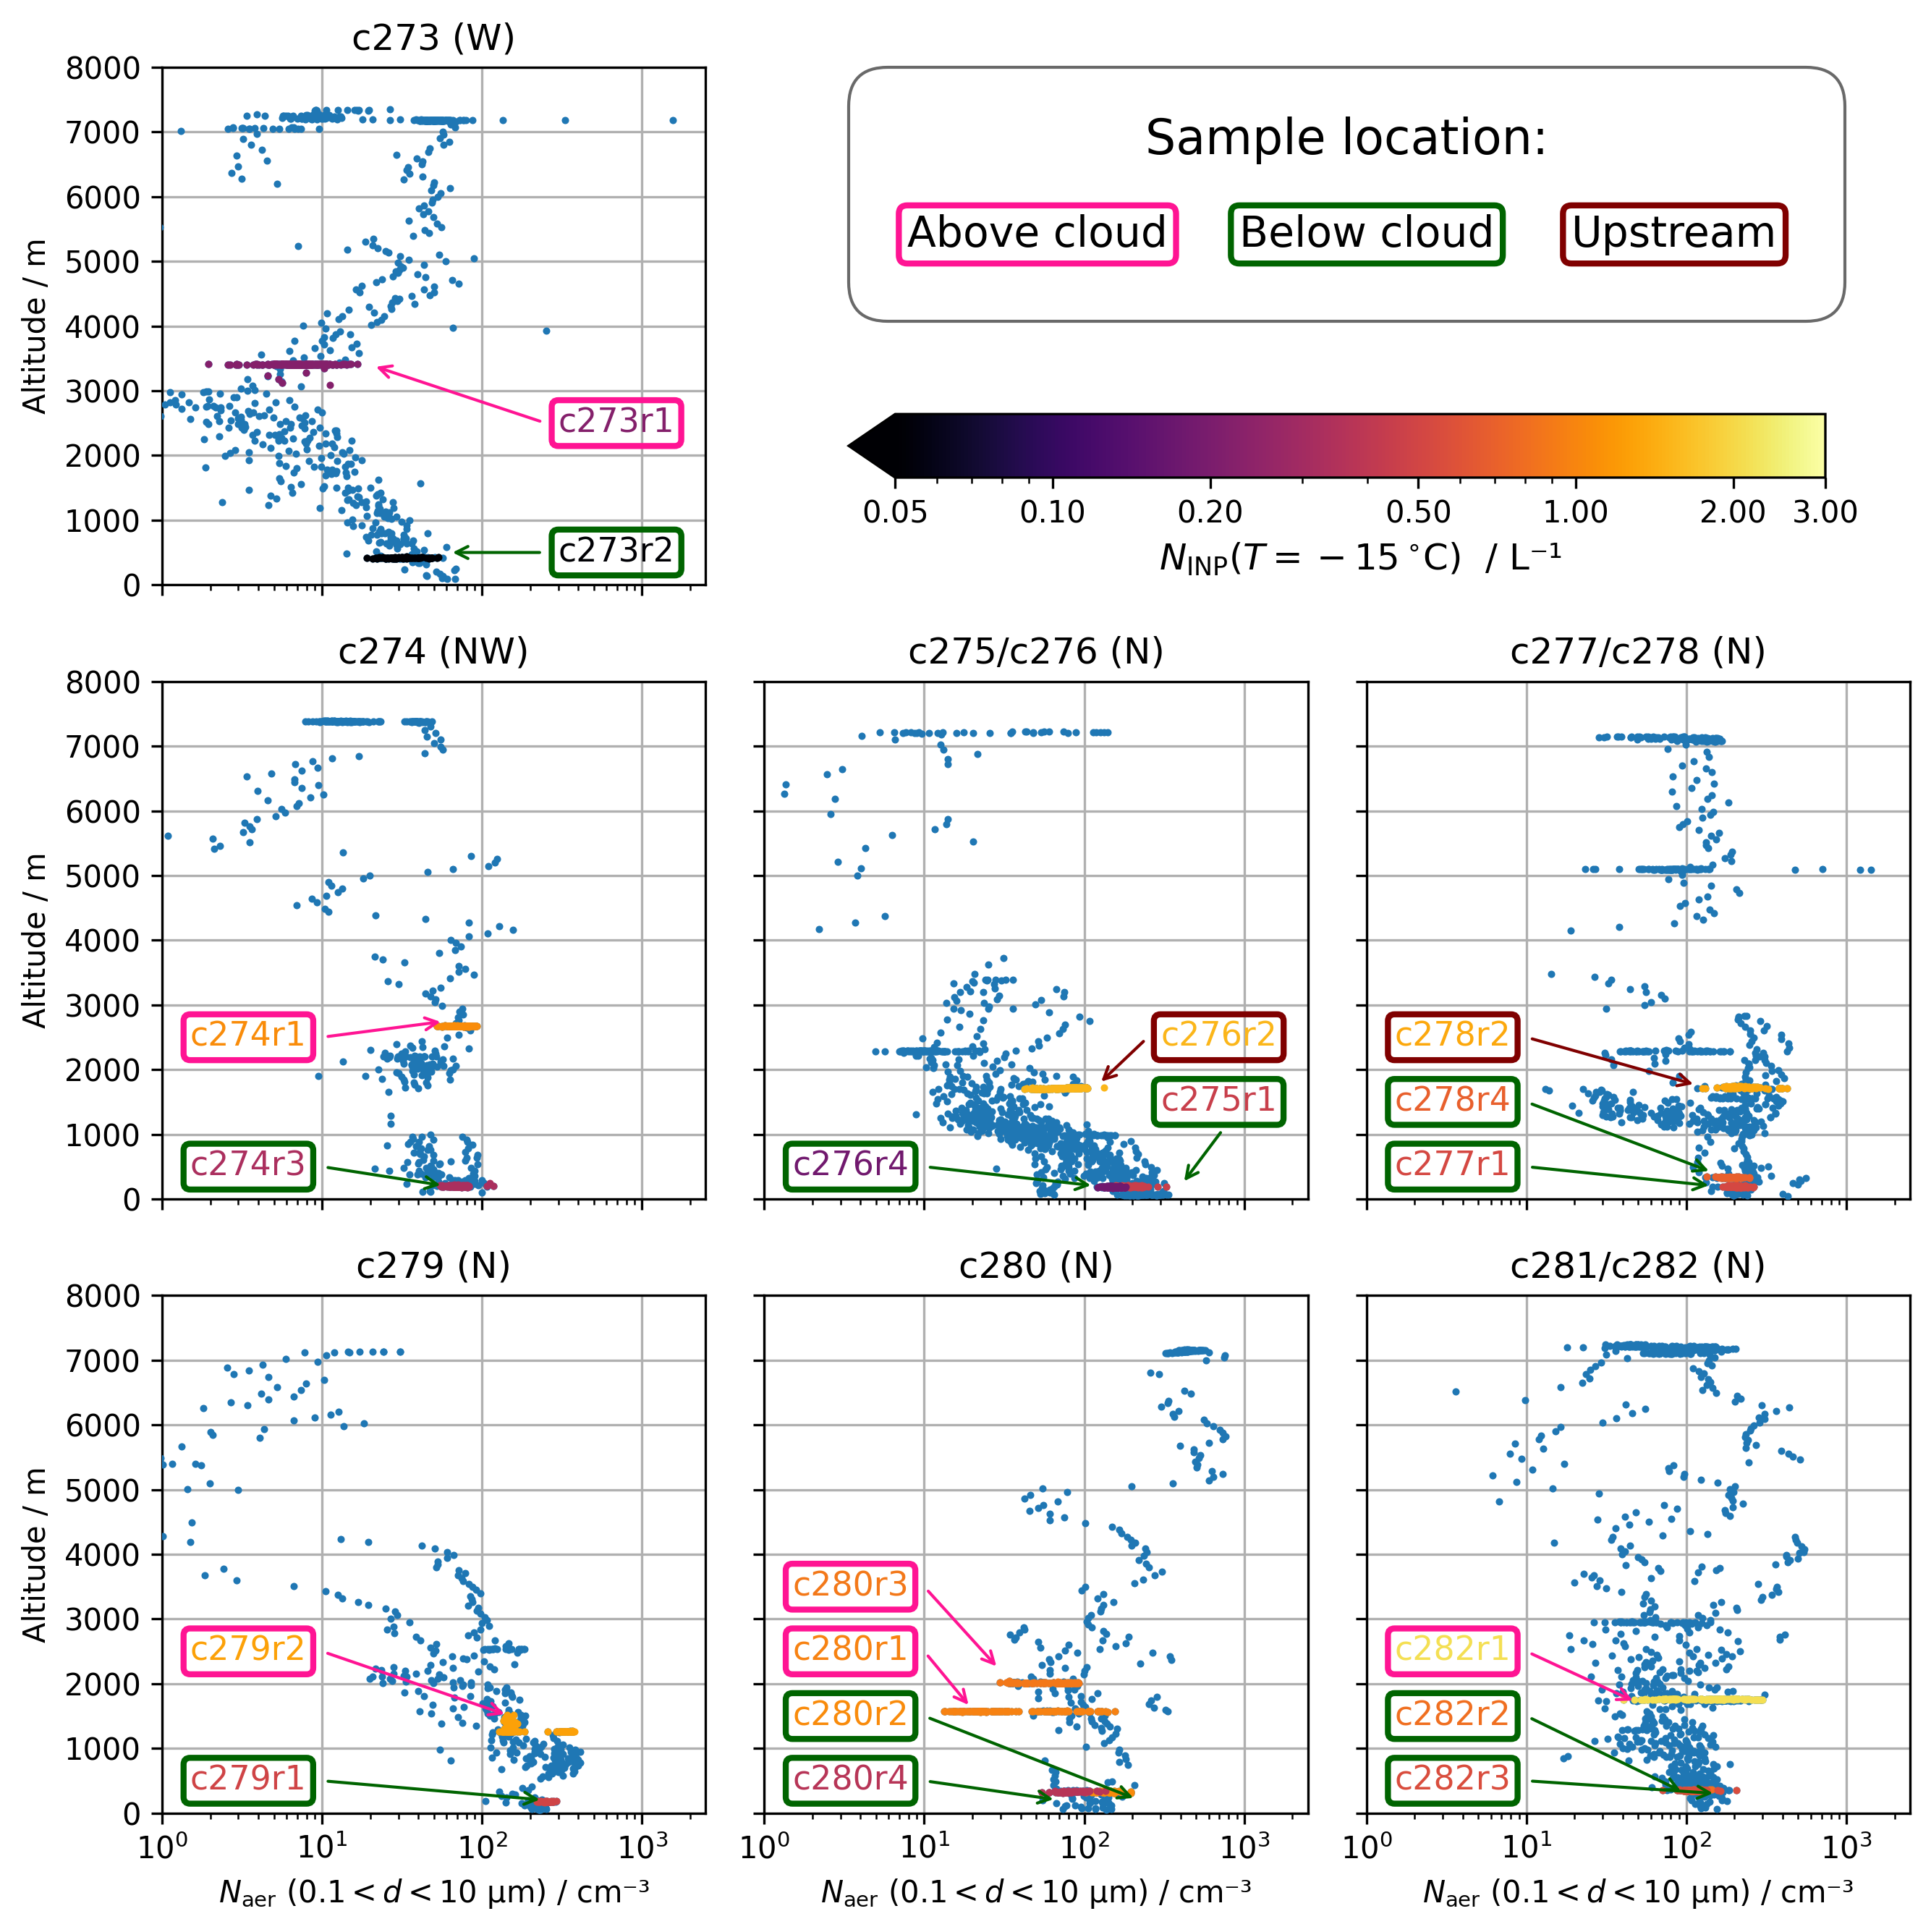

In [11]:
plt.close('all')
mosaic = [['c273_ax','.','.'],
          ['c274_ax','c275_6_ax','c277_8_ax'],
          ['c279_ax','c280_ax','c281_2_ax']]
fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(9,9), dpi=300,sharex=True,sharey=True)
norm = mcolors.LogNorm(0.05,3)
cm = plt.cm.inferno

for fl in flight_timings.itertuples():
    # Get correct data files
    core_cloud_data_fn = glob(os.path.join(
        '/badc/faam/data/2022',fl.Index + '*/core_processed',
        'core-cloud*v601*'
    ))[-1]
    core_data_fn = glob(os.path.join(
        '/badc/faam/data/2022',fl.Index + '*/core_processed',
        'core_faam*'+fl.Index+'.nc'
    ))[-1]
    nev_data_fn = glob(os.path.join(
        '/home/users/erinraif/acao_data/nevzorov_data/',
        '*'+fl.Index+'*'))[0]

    flight_data = asd.get_data(core_cloud_data_fn, core_data_fn)
    nev_ds = xr.open_dataset(nev_data_fn, decode_times=False, engine='netcdf4')
    nev_ds = nev_ds.rename_dims({'TIME': 'time'})
    nev_ds = nev_ds.rename({'TIME': 'time'})
    nev_flag = nev_ds.CLRFLG_COMBINED
    
    flight_start = [fl.start]
    flight_end = [fl.stop]

    # Get correct axes to point to based on flight ID and set title correctly
    if fl.Index in ['c276', 'c278', 'c282']:
        profile_ax = axes['c' + str(int(fl.Index[1:])-1) + '_' + fl.Index[-1] + '_ax']
        profile_ax.set_title('c' + str(int(fl.Index[1:])-1) + '/' + fl.Index + ' (N)')
    elif fl.Index in ['c275', 'c277', 'c281']:
        profile_ax = axes[fl.Index + '_' + str(int(fl.Index[-1])+1) + '_ax']
    elif fl.Index == 'c273':
        profile_ax = axes[fl.Index + '_ax']
        profile_ax.set_title(fl.Index + ' (W)')
    elif fl.Index == 'c274':
        profile_ax = axes[fl.Index + '_ax']
        profile_ax.set_title(fl.Index + ' (NW)')
    else: #c279
        profile_ax = axes[fl.Index + '_ax']
        profile_ax.set_title(fl.Index + ' (N)')

    # Get the time-averaged data to plot
    dN, altitude_at_dN_times = get_plot_info(flight_data, nev_flag,
                                             flight_start, flight_end,10)
    profile_ax.scatter(dN.where(
                          (dN['LAT_GIN'] > 71.5) | (dN.LAT_GIN - 0.2 * dN.LON_GIN > 67),
                           drop=True),
                       altitude_at_dN_times.where(
                           (dN.LAT_GIN > 71.5) | (dN.LAT_GIN - 0.2 * dN.LON_GIN > 67),
                            drop=True),
                       s=2,color='tab:blue',alpha=1,zorder=3)

    # Label the graphs correctly.
    if fl.Index in ['c273','c274','c279']:
        profile_ax.set_ylabel('Altitude / m')
    if fl.Index in ['c279','c280','c282']:
        profile_ax.set_xlabel(r'$N_\mathrm{aer}$ ($0.1 < d < 10$ μm) / cm⁻³')
        profile_ax.xaxis.set_major_formatter(mticker.ScalarFormatter)

    # Run the same process, but for each leg.
    each_run_df = leg_timings_data[leg_timings_data['flight']==fl.Index]
    for run in each_run_df.itertuples():
        if run.Index != 'c278r3t':
            lst, let = get_leg_timings(run)
            dN, altitude_at_dN_times = get_plot_info(flight_data, nev_flag, lst, let, 10)
            N_at_15 = INP_concentrations.loc[-15,run.Index+'_NT']
            c = cm(norm(N_at_15))
            profile_ax.scatter(dN.where(
                          (dN['LAT_GIN'] > 71.5) | (dN.LAT_GIN - 0.2 * dN.LON_GIN > 67),
                           drop=True),
                       altitude_at_dN_times.where(
                           (dN.LAT_GIN > 71.5) | (dN.LAT_GIN - 0.2 * dN.LON_GIN > 67),
                            drop=True),
                               s=2,color=c,alpha=1,zorder=4)

    # Set the axes parameters
    profile_ax.set_xscale('log')
    profile_ax.set_xlim(1,2500)
    profile_ax.set_ylim(0,8000)
    profile_ax.grid(True)

# Add colourbar
cax = fig.add_axes([0.44, 0.75, 0.5, 0.0325])
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
cb = plt.colorbar(sm, cax=cax, orientation="horizontal", extend='min', ticks=[0.05, 0.1, 0.2, 0.5, 1, 2, 3],
                 format=mticker.ScalarFormatter())
cb.set_label(r'$N_{\mathrm{INP}}\left(T=-15\,^{\circ}\mathrm{C}\right)$  / L⁻¹', fontsize=12)

# Add labels for each run
for row in annotations.itertuples():
    N_at_15 = INP_concentrations.loc[-15,row.label+'t_NT']
    c = cm(norm(N_at_15))
    t = axes[row.axes].text(row.text_loc_x, row.text_loc_y, row.label,
                 horizontalalignment='left',
                 verticalalignment='center',
                 color = c,
                 fontsize = 11,
                 zorder=7,
                 bbox=dict(boxstyle='round,pad=0.2',
                           edgecolor=row.color,
                           facecolor='none',
                           alpha=1,
                           linewidth=2)
                )
    bbox = t.get_window_extent()
    bbox = axes[row.axes].transAxes.inverted().transform(bbox)
    bbox_x0, bbox_x1 = bbox[0]
    bbox_y0, bbox_y1 = bbox[1]
    box_height_mp = (bbox_y0+bbox_y1)/2
    if row.text_loc_x == 1.5: # LHS
        arrow_start = (10, row.text_loc_y)
    else: # RHS
        arrow_start = (250, row.text_loc_y)
    # Exception for c275r1
    if row.label == 'c275r1':
        arrow_start = (750, 1100)
    arrow_end = (row.arrow_end_x, row.arrow_end_y)
    arrow = axes[row.axes].annotate("", xy=arrow_end, xytext=arrow_start,
                        arrowprops=dict(arrowstyle='->', linewidth=1,color=row.color),
                       zorder=1000)

# Manually make legend for textboxes
rounded_rect = mpatches.FancyBboxPatch((0.46, 0.85), 0.47, 0.09, 
                              boxstyle="round,pad=0.02", 
                              transform=fig.transFigure,  # Use figure coordinates
                              edgecolor='dimgray', 
                              facecolor='none', 
                              linewidth=1)

fig.patches.append(rounded_rect)

fig.text(0.695, 0.935, 'Sample location:',
             horizontalalignment='center',
             verticalalignment='top',
             color = 'black',
             fontsize = 16,
             zorder=7,
            )

fig.text(0.47, 0.885, "Above cloud",
             horizontalalignment='left',
             verticalalignment='top',
             color = 'black',
             fontsize = 14,
             zorder=8,
             bbox=dict(boxstyle='round,pad=0.2',
                       edgecolor='deeppink',
                       facecolor='none',
                       linewidth=2)
            )
fig.text(0.64, 0.885, "Below cloud",
             horizontalalignment='left',
             verticalalignment='top',
             color = 'black',
             fontsize = 14,
             zorder=8,
             bbox=dict(boxstyle='round,pad=0.2',
                       edgecolor='darkgreen',
                       facecolor='none',
                       linewidth=2)
            )
fig.text(0.81, 0.885, "Upstream",
             horizontalalignment='left',
             verticalalignment='top',
             color = 'black',
             fontsize = 14,
             zorder=8,
             bbox=dict(boxstyle='round,pad=0.2',
                       edgecolor='maroon',
                       facecolor='none',
                       linewidth=2)
            )

fig.tight_layout() 
fig.savefig('imgs/f06.pdf')
